In [28]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sign-language-mnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3258%2F5337%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T123347Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8e070519b9dc3a955a0a4856d3f21c9528f0e610557ea9840d6dc2fa518b1e03e248c706dc9da1aac99c3ea239083a2df57889c446ff2263106c5336c0a0681428d3b8b3b6938b7f7f0d0dd25677359892abbb1a506266b0652b2abc7b5315818662eea143cf32310365a9da67aed67cc29bc974841981f20a309496a36ef00a702c66b3e71fd38e5a6d69545a27e0c8cee3d9863c572b442c64f235ad4c32193fee013482b561010b7e68df467d28102dd31eae36baf660628e9179b4b6d3ef818e1c487ee09cebff1a1d8e38f2ce2c9b8aabef82d485adf0a29f7bbdb0e6b5b07324baf382ae87a05550d3d4e28d2da6bd74f93fe4fa904fc03cf27674fa4a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 65633206 bytes downloaded
Downloaded and uncompressed: sign-language-mnist
Data source import complete.


# Overview <a id = "cont"></a>
- [Data Review And Data Prepare](#1)
- [Generative Adversarial Networks(GANs)](#2)
    - [Create Generator](#2a)
    - [Create Discriminator](#2b)
    - [Create GANs](#2c)
    - [Train Model](#2d)
    - [Save Model](#2e)
    - [Visualizetion Result Of GANs](#2f)


In [29]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


# Data Review And Data Prepare <a id = "1"></a>


In [7]:
# Read the data with pandas library
train = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [8]:
# Train data
print("Train shape: ", train.shape)
train

Train shape:  (27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [9]:
# Test data
print("Test shape: ", test.shape)
test

Test shape:  (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


prepared x and y values.

In [10]:
x_train = train.drop(labels = ["label"], axis = 1)
y_train = train["label"]

x_test = test.drop(labels = ["label"], axis = 1)
y_test = test["label"]

In [11]:
x_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


In [12]:
y_train

0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64

 visualizing the images in the dataset.

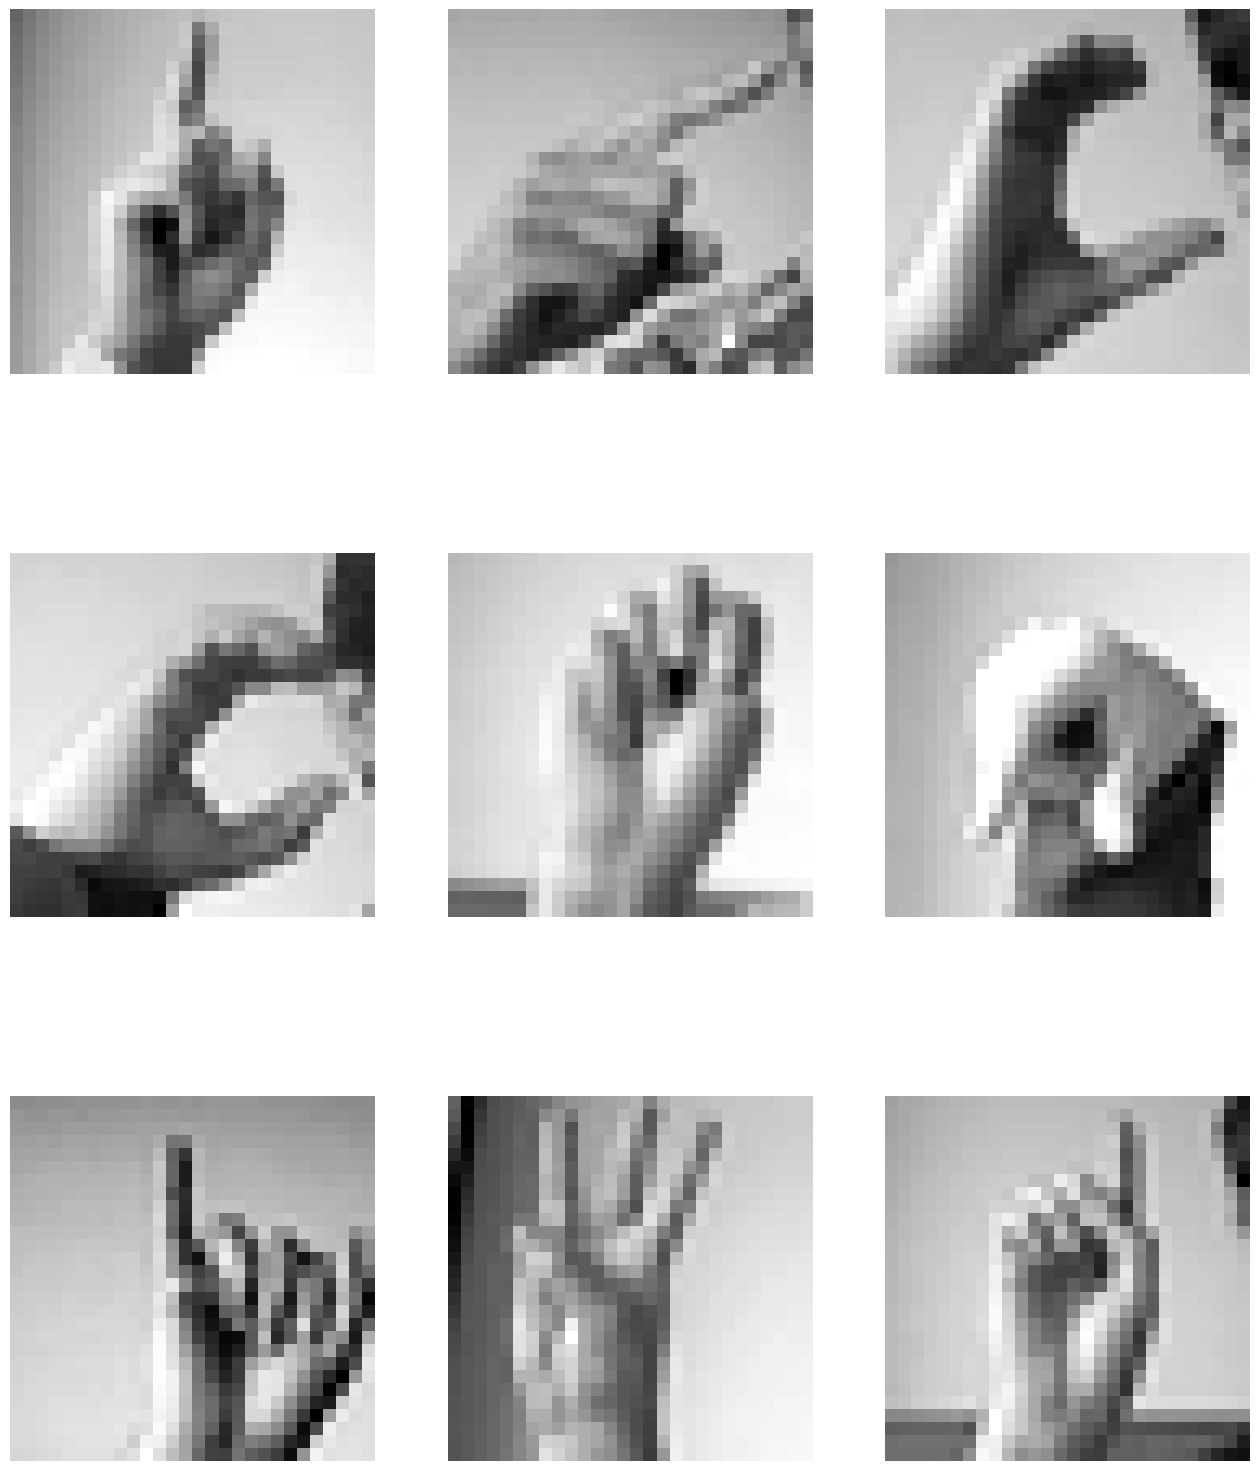

In [13]:
k = 0
row, col = 3, 3
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(16,20),)
for i in range(row):
    for j in range(col):
        img = x_train.iloc[k].to_numpy()
        img = img.reshape((28,28))
        ax[i,j].imshow(img,cmap = "gray")
        ax[i,j].axis("off")
        k += 1
plt.show()

Reduced the values of the dataset between zero-one.

In [14]:
x_train = x_train / 255.0 # Normalization
x_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.419608,0.462745,0.498039,0.525490,0.545098,0.560784,0.572549,0.588235,0.600000,0.611765,...,0.811765,0.811765,0.811765,0.811765,0.807843,0.807843,0.807843,0.800000,0.796078,0.792157
1,0.607843,0.615686,0.611765,0.611765,0.611765,0.615686,0.611765,0.619608,0.619608,0.615686,...,0.270588,0.584314,0.501961,0.341176,0.368627,0.639216,0.686275,0.403922,0.529412,0.584314
2,0.733333,0.737255,0.737255,0.733333,0.733333,0.729412,0.733333,0.737255,0.733333,0.729412,...,0.792157,0.788235,0.784314,0.780392,0.776471,0.780392,0.776471,0.764706,0.760784,0.764706
3,0.827451,0.827451,0.831373,0.831373,0.827451,0.823529,0.827451,0.823529,0.823529,0.827451,...,0.921569,0.917647,0.913725,0.905882,0.901961,0.886275,0.882353,0.870588,0.898039,0.639216
4,0.643137,0.654902,0.666667,0.674510,0.690196,0.701961,0.705882,0.721569,0.725490,0.729412,...,0.360784,0.411765,0.411765,0.423529,0.521569,0.639216,0.615686,0.639216,0.643137,0.701961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,0.741176,0.741176,0.745098,0.745098,0.752941,0.756863,0.756863,0.756863,0.756863,0.760784,...,0.517647,0.647059,0.388235,0.301961,0.203922,0.784314,0.917647,0.784314,0.870588,0.882353
27451,0.592157,0.603922,0.615686,0.619608,0.627451,0.631373,0.639216,0.643137,0.650980,0.654902,...,0.776471,0.776471,0.776471,0.776471,0.776471,0.768627,0.764706,0.764706,0.764706,0.760784
27452,0.682353,0.682353,0.682353,0.682353,0.682353,0.686275,0.686275,0.682353,0.678431,0.678431,...,0.474510,0.768627,0.819608,0.815686,0.807843,0.800000,0.796078,0.792157,0.784314,0.784314
27453,0.694118,0.709804,0.721569,0.725490,0.733333,0.741176,0.745098,0.749020,0.749020,0.745098,...,0.466667,0.219608,0.105882,0.227451,0.400000,0.309804,0.184314,0.250980,0.341176,0.364706


visualizing the normalized images.

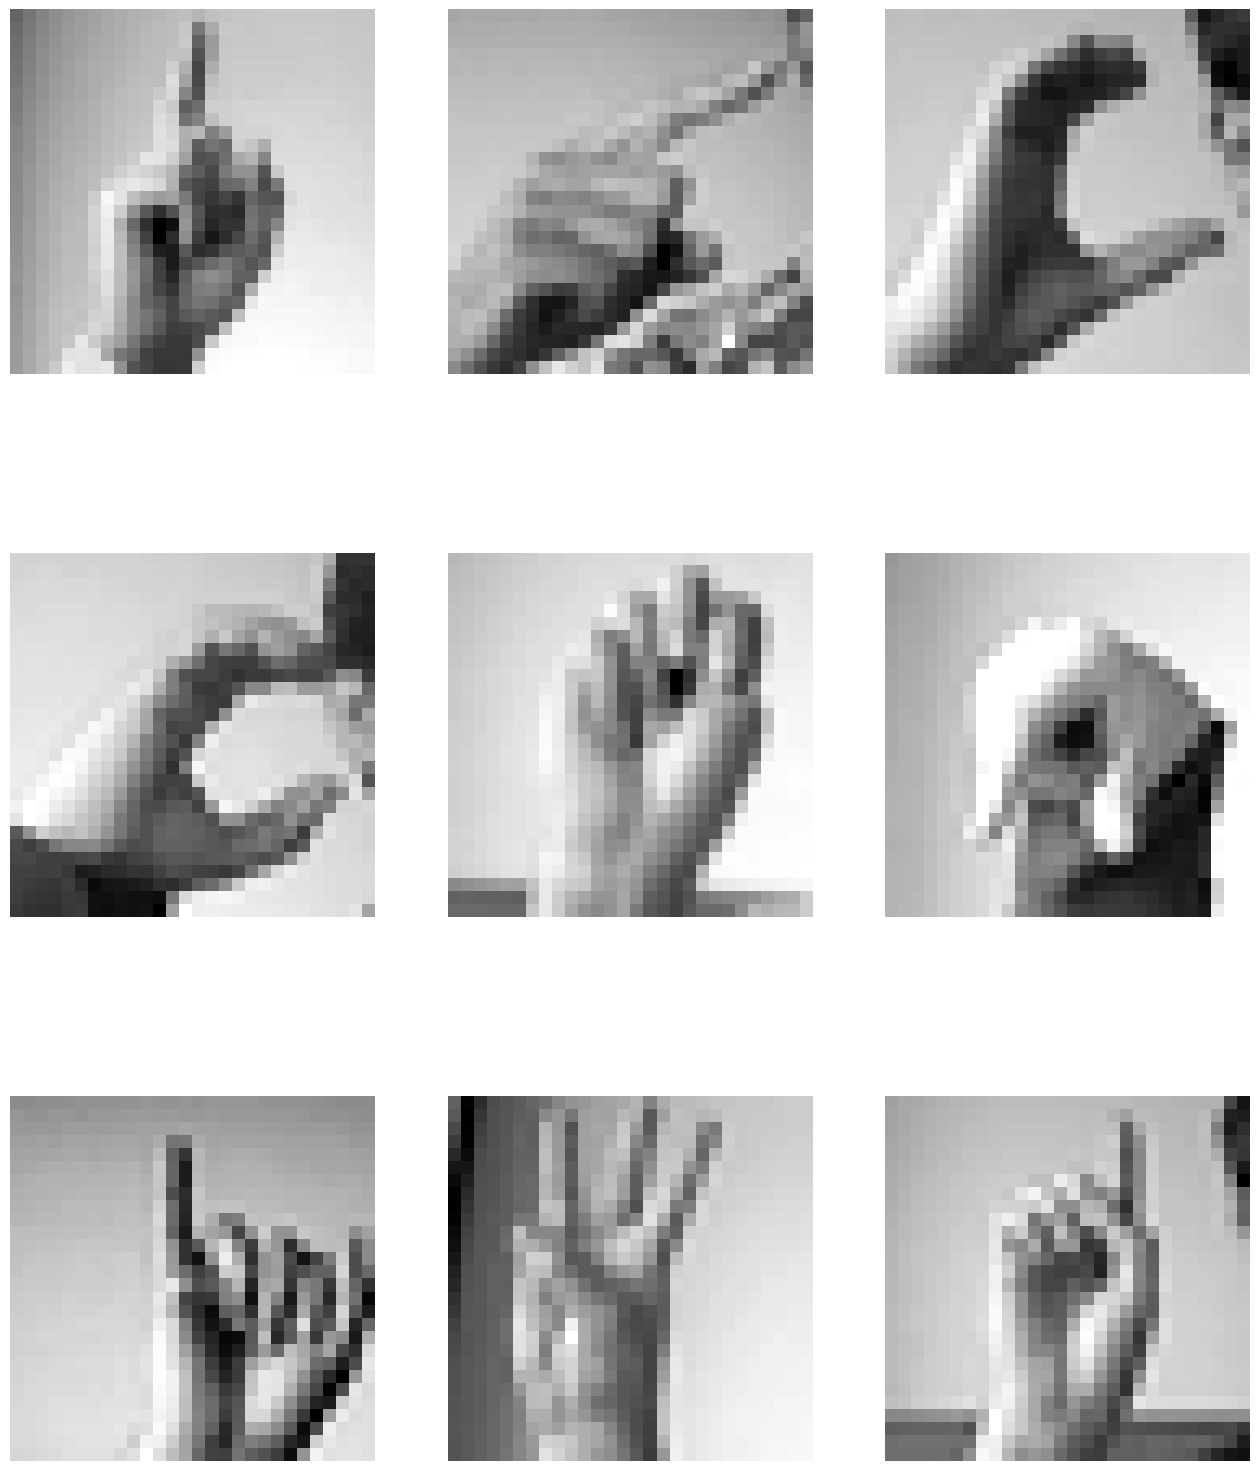

In [15]:
k = 0
row, col = 3, 3
fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(16,20),)
for i in range(row):
    for j in range(col):
        img = x_train.iloc[k].to_numpy()
        img = img.reshape((28,28))
        ax[i,j].imshow(img,cmap = "gray")
        ax[i,j].axis("off")
        k += 1
plt.show()

In [16]:
x_train = x_train.to_numpy()
x_train = x_train * 2 - 1
print("x_train shape: ", x_train.shape)
x_train

x_train shape:  (27455, 784)


array([[-0.16078431, -0.0745098 , -0.00392157, ...,  0.6       ,
         0.59215686,  0.58431373],
       [ 0.21568627,  0.23137255,  0.22352941, ..., -0.19215686,
         0.05882353,  0.16862745],
       [ 0.46666667,  0.4745098 ,  0.4745098 , ...,  0.52941176,
         0.52156863,  0.52941176],
       ...,
       [ 0.36470588,  0.36470588,  0.36470588, ...,  0.58431373,
         0.56862745,  0.56862745],
       [ 0.38823529,  0.41960784,  0.44313725, ..., -0.49803922,
        -0.31764706, -0.27058824],
       [ 0.40392157,  0.41176471,  0.41176471, ...,  0.60784314,
         0.63921569,  0.68627451]])

# Generative Adversarial Networks(GANs) <a id = "2"></a>

**What is the Generative Adversarial Networks(GANs)?**

A generative adversarial network (GAN) is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in June 2014. Two neural networks contest with each other in a game in the form of a zero-sum game, where one agent's gain is another agent's loss.



- Generator: Generate fake images.
- Discriminator: Decide whether the image is fake or real.
- To create a better fake picture, after the decision part, the fake picture created by going back to the generator section during the training is developing.

## Create Generator <a id = "2a"></a>


In [17]:
def create_generator():

    generator = Sequential()
    generator.add(Dense(units = 256, input_dim = 100))
    generator.add(ReLU())

    generator.add(Dense(units = 512))
    generator.add(ReLU())

    generator.add(Dense(units = 1024))
    generator.add(ReLU())

    generator.add(Dense(units = 784, activation = "tanh"))

    generator.compile(loss = "binary_crossentropy",
                     optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5))

    return generator

In [18]:
# Structure of Generator model
g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

##  Create Discriminator <a id = "2b"></a>


In [19]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024, input_dim = 784))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units = 512))
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units = 256))
    discriminator.add(ReLU())

    discriminator.add(Dense(units = 1, activation = "sigmoid"))

    discriminator.compile(loss = "binary_crossentropy",
                         optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5))

    return discriminator

In [20]:
# Structure of discriminator model
d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 re_lu_3 (ReLU)              (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_4 (ReLU)              (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

## Create GANs <a id = "2c"></a>


In [21]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape = (100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

In [22]:
# Structure of GANs model
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2946577 (11.24 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________


## Train Model <a id = "2d"></a>


Training GANs model with the dataset.

In [23]:
import time

epochs = 250
batch_size = 128

dis_loss = []
gen_loss = []

for e in range(epochs):
    for _ in range(batch_size):
        start = time.time()
        noise = np.random.normal(0, 1, [batch_size, 100])

        generated_image = g.predict(noise)

        image_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)]

        x = np.concatenate([image_batch, generated_image])

        y_dis = np.zeros(batch_size*2)
        y_dis[:batch_size] = 0.9

        d.trainable = True
        dloss = d.train_on_batch(x, y_dis)


        noise = np.random.normal(0, 1, [batch_size, 100])

        y_gen = np.ones(batch_size)

        d.trainable = False

        gloss =  gan.train_on_batch(noise, y_gen)

        end = time.time()
        process_time = str(end - start)

    dis_loss.append(dloss)
    gen_loss.append(gloss)

    print("Epoch: {}, Time: {}s, Generator Loss: {:.3f}, Discriminator Loss: {:.3f}".format(e, process_time[2:4], gloss, dloss))

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 9ms/step
Epoch: 211, Time: 26s, Generator Loss: 3.316, Discriminator Loss: 0.373
4/4 [==============================] - 0s 9ms/step
Epoch: 212, Time: 26s, Generator Loss: 3.561, Discriminator Loss: 0.304
4/4 [==============================] - 0s 10ms/step
Epoch: 213, Time: 39s, Generator Loss: 3.281, Discriminator Loss: 0.329
4/4 [==============================] - 0s 16ms/step
Epoch: 214, Time: 26s, Generator Loss: 3.245, Discriminator Loss: 0.335
4/4 [==============================] - 0s 8ms/step
Epoch: 215, Time: 23s, Generator Loss: 3.369, Discriminator Loss: 0.323
4/4 [==============================] - 0s 8ms/step
Epoch: 216, Time: 24s, Generator Loss: 3.184, Discriminator Loss: 0.307
4/4 [==============================] - 0s 8ms/step
Epoch: 217, Time: 25s, Generator Loss: 3.587, Discriminator Loss: 0.301
4/4 [==============================] - 0s 8ms/step
Epoch: 218, Time: 26s, Generator Lo

## Save Model <a id = "2e"></a>




In [24]:
g.save_weights("gans_model.h5")

## Visualization Result Of GANs <a id = "2f"></a>




4/4 [==============================] - 0s 6ms/step


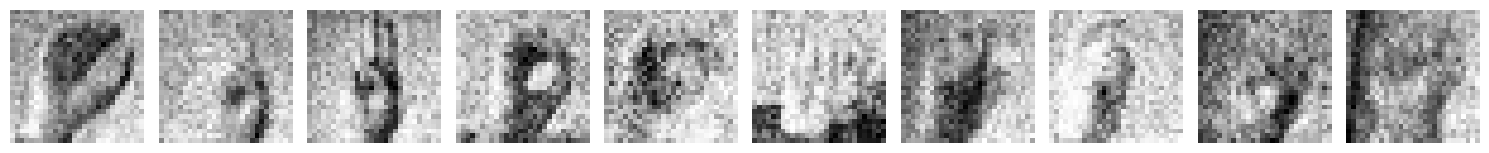

In [25]:
noise = np.random.normal(loc = 0, scale = 1, size = [100,100])
generated_image = g.predict(noise)
generated_image = generated_image.reshape(100, 28, 28)
plt.figure(figsize=(15,17))
for i in range(0,10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_image[i], interpolation = "nearest", cmap = "gray")
    plt.axis("off")
    plt.tight_layout()
plt.show()

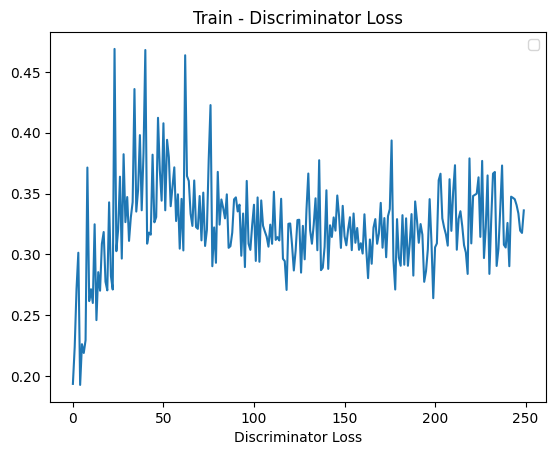

In [26]:
# Train and Test Discriminator Loss graphic
epochs_number = []
for i in range(0,epochs):
    epochs_number.append(i)

plt.plot(epochs_number, dis_loss)
plt.title("Train - Discriminator Loss")
plt.xlabel("Number of Epochs")
plt.xlabel("Discriminator Loss")
plt.legend()
plt.show()

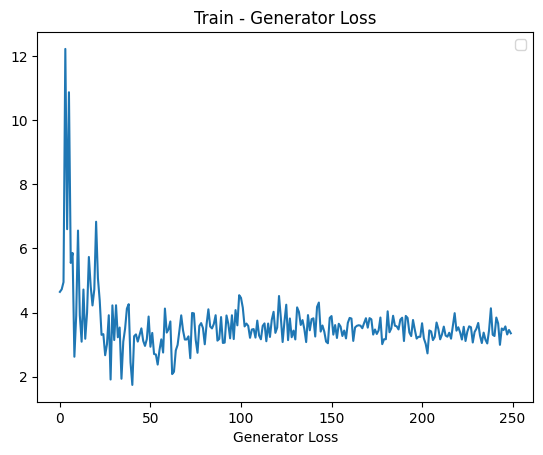

In [27]:
# Train and Test Generator Loss graphic
plt.plot(epochs_number, gen_loss)
plt.title("Train - Generator Loss")
plt.xlabel("Number of Epochs")
plt.xlabel("Generator Loss")
plt.legend()
plt.show()